# 2D Transient Stokes Flow in an Open Channel

## Overview

This notebook demonstrates the solution of 2D transient Stokes flow in an open channel using the finite element method with Julia and Ferrite.jl. 

## Section 1: Problem Definition

### Physical Setup

We consider a **2D rectangular open channel** with the following characteristics:

- **Geometry**: Rectangular domain with length $L$ and height $H$
- **Flow regime**: Viscous, incompressible, laminar flow (Stokes flow)
- **Time dependence**: Transient flow starting from rest

### Domain Description

The channel has four boundaries:
1. **Inlet (left)**: Prescribed parabolic velocity profile
2. **Outlet (right)**: Fixed pressure boundary
3. **Top wall**: No-slip boundary condition
4. **Bottom wall**: No-slip boundary condition


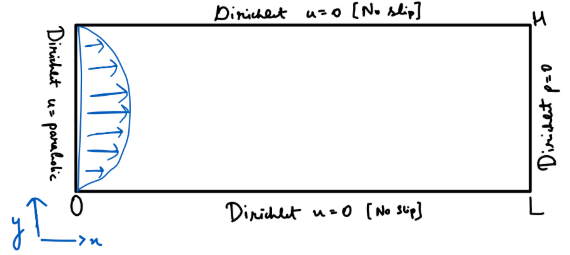

## Section 2: Mathematical Formulation and Boundary Conditions

### Governing Equations

The transient Stokes flow is governed by the following system of equations:

#### Momentum Equation
$$\frac{\partial \mathbf{u}}{\partial t} - \mu \nabla^2 \mathbf{u} + \nabla p = \mathbf{f} \quad \text{in } \Omega$$

#### Continuity Equation (Incompressibility)
$$\nabla \cdot \mathbf{u} = 0 \quad \text{in } \Omega$$

**where:**
- $\mathbf{u} = (u_x, u_y)^T$ is the velocity vector
- $p$ is the pressure field
- $\mu$ is the dynamic viscosity
- $\mathbf{f}$ is the body force  (zero for our case)
- $\Omega$ is the flow domain

### Boundary Conditions

#### 1. Inlet Boundary (Parabolic Inflow)
At the left boundary ($x = 0$):
$$\mathbf{u}(0, y, t) = \begin{pmatrix} u_{\text{in}}(y, t) \\ 0 \end{pmatrix}$$

where the parabolic profile is:
$$u_{\text{in}}(y, t) = v_{\text{in}}(t) \cdot \frac{y(H-y)}{H^2/4}$$

with $v_{\text{in}}(t)$ being the time-dependent inlet velocity amplitude.

#### 2. Wall Boundaries (No-slip)
At the top and bottom walls ($y = 0$ and $y = H$):
$$\mathbf{u} = \mathbf{0}$$

#### 3. Outlet Boundary (Fixed Pressure)
At the right boundary ($x = L$):
$$p = 0$$
(for now we consider 0 mean pressure)

### Initial Conditions
At $t = 0$:
$$\mathbf{u}(\mathbf{x}, 0) = \mathbf{0}$$

### Weak Formulation

The weak formulation involves finding $\mathbf{u} \in \mathbf{V}$ and $p \in Q$ such that:

$$\int_\Omega \mathbf{v} \cdot \frac{\partial \mathbf{u}}{\partial t} \, d\Omega + \int_\Omega \mu \nabla \mathbf{v} : \nabla \mathbf{u} \, d\Omega - \int_\Omega (\nabla \cdot \mathbf{v}) p \, d\Omega = 0$$

$$\int_\Omega q (\nabla \cdot \mathbf{u}) \, d\Omega = 0$$

for all test functions $\mathbf{v} \in \mathbf{V}_0$ and $q \in Q$.

In [35]:
# Import required packages
using BlockArrays          # For blocked matrix operations
using LinearAlgebra        # Basic linear algebra operations
using SparseArrays         # Sparse matrix support
using Ferrite             # Finite element library
using Plots               # Plotting and visualization
using WriteVTK            # VTK output for ParaView

## Section 3: Assembly Functions - Stiffness Matrix, Mass Matrix, and Load Vector

### Mathematical Foundation

The finite element discretization of the Stokes system leads to a system of linear equations:

$$\mathbf{M} \frac{d\mathbf{u}}{dt} + \mathbf{K} \mathbf{u} = \mathbf{f}$$

where:
- **$\mathbf{M}$** is the **mass matrix** (from the time derivative term)
- **$\mathbf{K}$** is the **stiffness matrix** (from viscous and pressure terms)
- **$\mathbf{f}$** is the **load vector** (from body forces and boundary conditions)

### Mass Matrix Assembly

The mass matrix arises from the time derivative term $\frac{\partial \mathbf{u}}{\partial t}$:

$$M_{ij} = \int_\Omega \mathbf{N}_i \cdot \mathbf{N}_j \, d\Omega$$

**Key points:**
- Only velocity degrees of freedom contribute (no time derivative of pressure)
- Block structure: $\mathbf{M} = \begin{pmatrix} \mathbf{M}_{uu} & \mathbf{0} \\ \mathbf{0} & \mathbf{0} \end{pmatrix}$
- $\mathbf{N}_i$ are the vector-valued velocity shape functions

### Stiffness Matrix Assembly

The stiffness matrix combines viscous and pressure coupling terms:

$$K_{ij} = \int_\Omega \mu \nabla \mathbf{N}_i : \nabla \mathbf{N}_j \, d\Omega - \int_\Omega (\nabla \cdot \mathbf{N}_i) N_j^p \, d\Omega - \int_\Omega N_i^p (\nabla \cdot \mathbf{N}_j) \, d\Omega$$

**Block structure:**
$$\mathbf{K} = \begin{pmatrix} 
\mathbf{K}_{uu} & \mathbf{K}_{up} \\ 
\mathbf{K}_{pu} & \mathbf{0}
\end{pmatrix}$$

where:
- $\mathbf{K}_{uu}$: velocity-velocity coupling (viscous term)
- $\mathbf{K}_{up}$: velocity-pressure coupling (pressure gradient)
- $\mathbf{K}_{pu}$: pressure-velocity coupling (continuity constraint)

### Implementation Strategy

1. **Element-wise assembly**: Loop over all elements
2. **Quadrature integration**: Use Gauss quadrature for accurate integration
3. **Shape function evaluation**: Compute values, gradients, and divergences
4. **Global assembly**: Accumulate local contributions to global matrices

In [ ]:
    function assemble_mass_matrix!(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    """
    Assemble the mass matrix for the transient Stokes system.
    
    The mass matrix M has the block structure:
    M = [M_uu  0  ]
        [0     0  ]
    
    Only the velocity-velocity block (M_uu) is non-zero since there's no time derivative of pressure.
    """
    
    # Get dimensions for block structure
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    
    # Block indices: 1 = velocity, 2 = pressure
    v▄, p▄ = 1, 2
    
    # Local element mass matrix (blocked)
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), 
                     [n_basefuncs_v, n_basefuncs_p], 
                     [n_basefuncs_v, n_basefuncs_p])

    # Initialize assembler
    mass_assembler = start_assemble(M)
    
    # Element loop
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        # Quadrature loop
        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            
            # Velocity-velocity mass matrix: ∫ Nᵢ · Nⱼ dΩ
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    # Dot product for vector shape functions
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        
        # Assemble local matrix to global matrix
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end

assemble_mass_matrix! (generic function with 1 method)

In [37]:
function assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
    """
    Assemble the stiffness matrix for the Stokes system.
    
    The stiffness matrix K has the block structure:
    K = [K_uu  K_up]
        [K_pu   0  ]
    
    where:
    - K_uu: viscous term (∫ μ ∇u : ∇v dΩ)
    - K_up: pressure gradient term (∫ -p ∇·v dΩ)
    - K_pu: continuity constraint (∫ -q ∇·u dΩ)
    """
    
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    
    # Get DOF ranges for velocity and pressure
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    
    # Pre-allocate arrays for shape function values
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)        # Velocity shape functions
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # Velocity gradients (2×2 tensor)
    divϕᵤ = Vector{Float64}(undef, ndofs_u)             # Velocity divergences
    ϕₚ = Vector{Float64}(undef, ndofs_p)                # Pressure shape functions
    
    # Element loop
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        ke .= 0
        
        # Quadrature loop
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            
            # Evaluate shape functions at quadrature point
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            
            # K_uu: Viscous term ∫ μ ∇u : ∇v dΩ
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += viscosity * (∇ϕᵤ[i] ⊡ ∇ϕᵤ[j]) * dΩ
            end
            
            # K_up: Pressure gradient term ∫ -p ∇·v dΩ
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += (-divϕᵤ[i] * ϕₚ[j]) * dΩ
            end
            
            # K_pu: Continuity constraint ∫ -q ∇·u dΩ
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += (-divϕᵤ[j] * ϕₚ[i]) * dΩ
            end
        end
        
        # Assemble local matrix to global matrix
        assemble!(assembler, celldofs(cell), ke)
    end
    
    return K
end

assemble_stokes_matrix! (generic function with 1 method)

## Section 4: Mesh Generation and Spatial Discretization Choices

### Domain Geometry

We define a rectangular channel with:
- **Length**: $L = 4H$ (length-to-height ratio of 4:1)
- **Height**: $H = 0.25$ (dimensionless units)


### Mesh Generation Strategy

**Element type**: Quadrilateral elements

**Mesh refinement**: 
- **Refinement ratio**: 4:1 horizontal to vertical elements (same as ratio of length to height)

In [38]:
# Mesh parameters
nelem = 10                      # Base number of elements
H = 0.25                        # Channel height
L = 4*H                         # Channel length (4:1 aspect ratio)
nels = (4*nelem, nelem)         # Elements in (x,y) directions

# Domain corners
left  = Vec((0., 0.))           # Bottom-left corner
right = Vec((L, H))             # Top-right corner

# Generate structured quadrilateral mesh
grid = generate_grid(Quadrilateral, nels, left, right)

# Add a vertex set for potential point constraints
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

println("Mesh generated successfully!")
println("Number of elements: ", getncells(grid))
println("Number of nodes: ", getnnodes(grid))
println("Domain: [0, $L] × [0, $H]")
println("Element dimensions: $(L/(4*nelem)) × $(H/nelem)")

Mesh generated successfully!
Number of elements: 400
Number of nodes: 451
Domain: [0, 1.0] × [0, 0.25]
Element dimensions: 0.025 × 0.025


## Section 5: Finite Element Spaces - Velocity and Pressure

#### Velocity Space: Quadratic Lagrange (Q₂)
- **Polynomial degree**: 2
- **Dimension**: 2 (vector field: $\mathbf{u} = (u_x, u_y)$)

Question to domenico: Why use quadratic Lagrange for velocity and linear for pressure?

#### Pressure Space: Linear Lagrange (Q₁)
- **Polynomial degree**: 1  
- **Dimension**: 1 (scalar field: $p$)

### Shape Function Properties

- **Velocity shape functions**: $\mathbf{N}_i^u : \Omega \rightarrow \mathbb{R}^2$
- **Pressure shape functions**: $N_i^p : \Omega \rightarrow \mathbb{R}$



In [39]:
# Finite element setup
dim = 2                                              # Spatial dimension
degree = 1                                           # Base polynomial degree

# Define interpolation spaces
# Velocity: Quadratic Lagrange (degree+1) for 2D vector field
ipu = Lagrange{RefQuadrilateral, degree+1}()^dim     # Q₂ × Q₂ (vector)
# Pressure: Linear Lagrange (degree) for scalar field  
ipp = Lagrange{RefQuadrilateral, degree}()           # Q₁ (scalar)

# Create DOF handler
dh = DofHandler(grid)
add!(dh, :u, ipu)    # Add velocity field
add!(dh, :p, ipp)    # Add pressure field
close!(dh)

# Quadrature rules for integration
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)    # 3-point Gauss rule
ipg = Lagrange{RefQuadrilateral, 1}()                # Linear geometric mapping

# Cell values for volume integration
cvu = CellValues(qr, ipu, ipg)    # Velocity cell values
cvp = CellValues(qr, ipp, ipg)    # Pressure cell values

CellValues(scalar, rdim=2, and sdim=2): 9 quadrature points
 Function interpolation: Lagrange{RefQuadrilateral, 1}()
Geometric interpolation: Lagrange{RefQuadrilateral, 1}()^2

## Section 6: Boundary Condition Implementation

### Boundary Condition Definitions

#### 1. Inlet Boundary: Parabolic Velocity Profile
- **Location**: Left boundary ($x = 0$)
- **Type**: Dirichlet BC for velocity
- **Profile**: $u_x(y,t) = v_{\text{max}}(t) \cdot \frac{y(H-y)}{H^2/4}$, $u_y = 0$
- **Time dependence**: Can be ramped or constant

#### 2. Wall Boundaries: No-slip Condition
- **Location**: Top and bottom boundaries ($y = 0, H$)
- **Type**: Dirichlet BC for velocity
- **Value**: $\mathbf{u} = \mathbf{0}$

#### 3. Outlet Boundary: Fixed Pressure
- **Location**: Right boundary ($x = L$)
- **Type**: Dirichlet BC for pressure
- **Value**: $p = 0$ (reference pressure)

### Mathematical Formulation

The parabolic inlet profile ensures:
- **Zero velocity** at walls ($y = 0, H$)
- **Maximum velocity** at centerline ($y = H/2$)
- **Parabolic shape** matches analytical solution for fully developed flow

In [40]:
# Initialize constraint handler
ch = ConstraintHandler(dh)

# Physical parameters
vmax = 1.0                      # Maximum inlet velocity

# Time-dependent inlet velocity (choose one)
vin(t) = vmax                   # Constant velocity (steady case)
# vin(t) = min(t * vmax, vmax)   # Ramped velocity (transient case)

# Parabolic inlet profile function
function parabolic_inflow_profile(x, t)
    y = x[2]  # y-coordinate
    # Parabolic profile: u_x = v_in(t) * y*(H-y)/(H²/4), u_y = 0
    u_x = vin(t) * y * (H - y) / (H^2 / 4)
    u_y = 0.0
    return Vec((u_x, u_y))
end

# 1. Inlet boundary condition (parabolic velocity profile)
inlet = getfacetset(grid, "left")

dbc_inlet = Dirichlet(:u, inlet, parabolic_inflow_profile)
add!(ch, dbc_inlet)

# 2. Wall boundaries (no-slip condition)
wall = union(
    getfacetset(grid, "top"),
    getfacetset(grid, "bottom")
)
dbc_walls = Dirichlet(:u, wall, (x, t) -> Vec((0.0, 0.0)))
add!(ch, dbc_walls)

# 3. Outlet boundary (fixed pressure)
outlet = getfacetset(grid, "right")
dbc_outlet = Dirichlet(:p, outlet, (x, t) -> 0.0)
add!(ch, dbc_outlet)

# Finalize constraint handler
close!(ch)

println("Boundary conditions set up successfully!")
println("Number of constrained DOFs: ", length(ch.prescribed_dofs))
println("Number of free DOFs: ", length(ch.free_dofs))
println("Inlet nodes: ", length(inlet))
println("Wall nodes: ", length(wall))
println("Outlet nodes: ", length(outlet))

Boundary conditions set up successfully!
Number of constrained DOFs: 373
Number of free DOFs: 3480
Inlet nodes: 10
Wall nodes: 80
Outlet nodes: 10


## Section 7: System Assembly and Solution

### System Matrix Structure

For the stationary Stokes problem, we solve:
$$\mathbf{K} \mathbf{u} = \mathbf{f}$$

where $\mathbf{K}$ is the stiffness matrix and $\mathbf{f}$ is the load vector.

### Assembly Process

1. **Allocate global matrices**: Use sparsity pattern based on DOF connectivity
2. **Assemble stiffness matrix**: Add element contributions using quadrature
3. **Apply boundary conditions**: Modify system to enforce constraints
4. **Solve linear system**: Use direct solver for the constrained system

### Matrix Coupling

The `coupling` parameter defines which DOF types interact:
```julia
coupling = [true  true ]  # [u-u  u-p]
           [true  false]  # [p-u  p-p]
```

- `true`: DOFs are coupled (create matrix entries)
- `false`: DOFs are decoupled (no matrix entries)


In [41]:
# Define coupling between DOF types
coupling = [true  true;   # u-u coupling (yes), u-p coupling (yes)
             true  false]  # p-u coupling (yes), p-p coupling (no)

# Allocate global stiffness matrix and load vector
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Physical parameters
viscosity = 1e3              # Dynamic viscosity
time = 0.0                   # Time for steady state

# Assemble the stiffness matrix
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)

# Apply boundary conditions
update!(ch, time)            # Update constraint handler to current time
apply!(K, f, ch)             # Apply constraints to matrix and RHS

# Solve the linear system
u = K \ f                    # Direct solve using sparse LU factorization

# Store solution for later analysis
u_stationary = copy(u)

# Export solution to VTK for visualization
VTKGridFile("stokes_2d_channel_solution", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

println("Solution exported to VTK format for ParaView visualization.")

Solution exported to VTK format for ParaView visualization.


## Section 8: Post-Processing and Visualization of Results

- **Velocity components**: Show $u_x$ and $u_y$ separately
- **Pressure field**: Display pressure distribution
- **Contour plots**: Use filled contours for clear visualization
- **Color maps**: Choose appropriate scales for each quantity

### Expected Results

For this open channel flow, we expect:
- **Inlet**: Parabolic velocity profile
- **Walls**: Zero velocity (no-slip condition)
- **Outlet**: Nearly developed flow profile
- **Pressure**: Decreasing linearly from inlet to outlet

In [42]:
function postprocess_solution(u, dh, nels)
    """
    Post-process the solution to extract velocity and pressure fields.
    
    Returns:
    - area: Element areas (for verification)
    - velx2d: x-velocity component as 2D array
    - vely2d: y-velocity component as 2D array  
    - pres2d: pressure as 2D array
    """
    
    # Initialize storage arrays
    area = Float64[]
    velx = Float64[]
    vely = Float64[]
    pres = Float64[]

    # Loop over all elements
    for (cell_num, cell) in enumerate(CellIterator(dh))
        
        # Get DOF ranges for velocity and pressure
        dof_range_u = dof_range(dh, :u)
        dof_range_p = dof_range(dh, :p)
        
        # Extract local DOF values
        uloc = u[celldofs(dh, cell_num)[dof_range_u]]
        ploc = u[celldofs(dh, cell_num)[dof_range_p]]
        
        # Reinitialize cell values for this element
        Ferrite.reinit!(cvu, cell)
        
        # Initialize element-averaged quantities
        cellarea = 0.0
        cellvelocity = [0.0, 0.0]
        cellpressure = 0.0
        
        # Integrate velocity over element
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            velocity = function_value(cvu, q_point, uloc)
            
            cellarea += dΩ
            cellvelocity += velocity * dΩ
        end
        
        # Integrate pressure over element
        for q_point in 1:getnquadpoints(cvp)
            dΩ = getdetJdV(cvp, q_point)
            pressure = function_value(cvp, q_point, ploc)
            cellpressure += pressure * dΩ
        end
        
        # Store element-averaged values
        push!(area, cellarea)
        push!(velx, cellvelocity[1])
        push!(vely, cellvelocity[2])
        push!(pres, cellpressure)
    end
    
    # Reshape to 2D arrays for plotting
    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, pres2d
end

postprocess_solution (generic function with 1 method)

Creating visualization plots...


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\rimaz\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


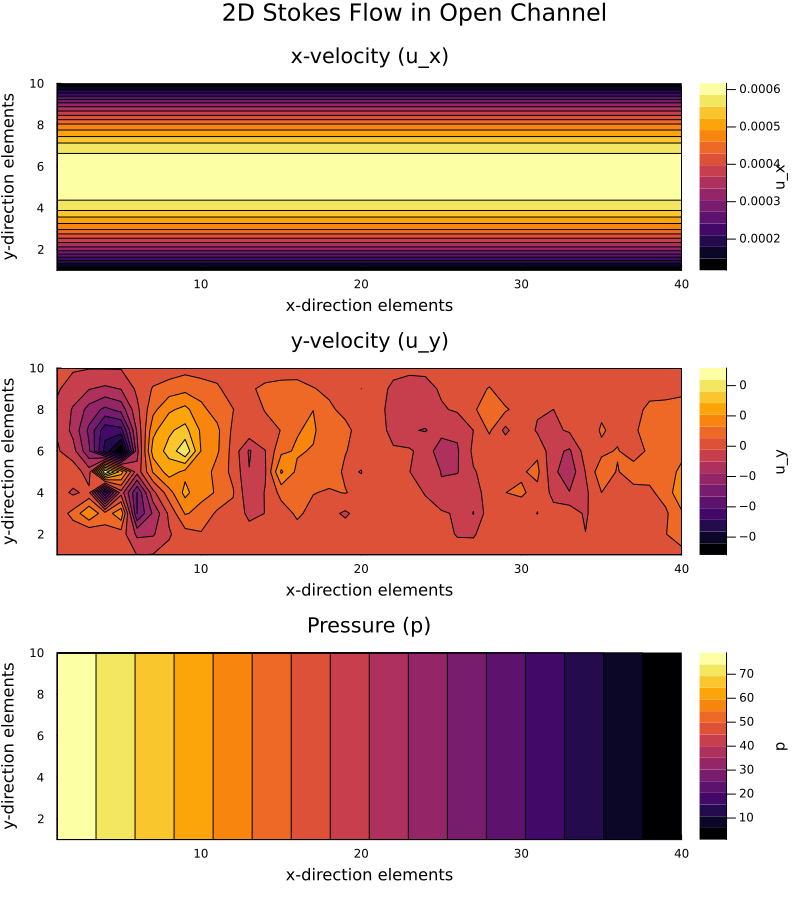

In [43]:
# Post-process the solution
# println("Post-processing solution...")
area, velx2d, vely2d, pres2d = postprocess_solution(u_stationary, dh, nels)

# Create visualization plots
println("Creating visualization plots...")

# Plot 1: x-velocity component
p1 = contour(velx2d', 
             fill=true, 
             title="x-velocity (u_x)", 
             xlabel="x-direction elements", 
             ylabel="y-direction elements",
             colorbar_title="u_x")

# Plot 2: y-velocity component  
p2 = contour(vely2d', 
             fill=true, 
             title="y-velocity (u_y)", 
             xlabel="x-direction elements", 
             ylabel="y-direction elements",
             colorbar_title="u_y")

# Plot 3: Pressure distribution
p3 = contour(pres2d', 
             fill=true, 
             title="Pressure (p)", 
             xlabel="x-direction elements", 
             ylabel="y-direction elements",
             colorbar_title="p")

# Combine plots in a single figure
combined_plot = plot(p1, p2, p3, 
                     layout=(3,1), 
                     size=(800, 900),
                     plot_title="2D Stokes Flow in Open Channel")

# Display the combined plot
display(combined_plot)

# # Print some statistics
# println("\nSolution statistics:")
# println("Maximum x-velocity: ", maximum(velx2d))
# println("Minimum x-velocity: ", minimum(velx2d))
# println("Maximum y-velocity: ", maximum(abs, vely2d))
# println("Maximum pressure: ", maximum(pres2d))
# println("Minimum pressure: ", minimum(pres2d))
# println("Total domain area: ", sum(area))

## Summary: Spatial Discretization Implementation

### Finite Element Discretization Details

The spatial discretization implemented in this notebook uses the following specific choices:

#### Element Type and Polynomial Orders
- **Velocity field**: Quadratic Lagrange elements (Q₂) with `degree+1 = 2`
- **Pressure field**: Linear Lagrange elements (Q₁) with `degree = 1`
- **Reference element**: `RefQuadrilateral` (bilinear quadrilateral)

#### Degrees of Freedom Structure
- **Velocity DOFs**: Vector-valued with 2 components per node (u_x, u_y)
- **Pressure DOFs**: Scalar-valued with 1 component per node
- **DOF ordering**: Velocity DOFs first, then pressure DOFs in global system

#### Mesh Structure
- **Domain discretization**: Structured quadrilateral mesh
- **Element distribution**: 4×nelem elements in x-direction, nelem elements in y-direction
- **Aspect ratio**: Element aspect ratio matches domain aspect ratio (4:1)

#### Matrix Assembly Process
1. **Element-wise loop**: Iterate over all elements using `CellIterator`
2. **Shape function evaluation**: Compute values, gradients, and divergences at quadrature points
3. **Local matrix assembly**: Build element matrices using numerical quadrature
4. **Global assembly**: Accumulate local contributions to global sparse matrices

#### Boundary Condition Implementation
- **Constraint handling**: Dirichlet conditions applied via `ConstraintHandler`
- **Matrix modification**: Constrained DOFs eliminated from system matrix
- **Solution enforcement**: Boundary values directly imposed in solution vector

This discretization results in a stable mixed finite element formulation that satisfies the inf-sup condition for the Stokes problem.

## Time Stepping Implementation

### Time Discretization Strategy

For the transient Stokes problem, we need to discretize the time derivative term:

$$\mathbf{M} \frac{d\mathbf{u}}{dt} + \mathbf{K} \mathbf{u} = \mathbf{f}$$

#### Implicit Euler Time Stepping

The most common approach uses implicit Euler discretization:

$$\mathbf{M} \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} + \mathbf{K} \mathbf{u}^{n+1} = \mathbf{f}^{n+1}$$

Rearranging gives the time-stepping system:

$$\left(\mathbf{M} + \Delta t \mathbf{K}\right) \mathbf{u}^{n+1} = \mathbf{M} \mathbf{u}^n + \Delta t \mathbf{f}^{n+1}$$

#### Implementation Steps

1. **Assemble mass matrix**: Use `assemble_mass_matrix!()` function
2. **Form time-stepping matrix**: $\mathbf{A} = \mathbf{M} + \Delta t \mathbf{K}$
3. **Apply boundary conditions**: Use `apply!(A, ch)` to modify system matrix
4. **Time stepping loop**:
   - Update boundary conditions: `update!(ch, t)`
   - Compute RHS: `b = M * u_old + Δt * f`
   - Apply RHS boundary conditions: `apply_rhs!(rhsdata, b, ch)`
   - Solve system: `u_new = A \ b`
   - Update solution: `u_old = u_new`

#### Key Ferrite.jl Functions for Time Stepping

- `assemble_mass_matrix!()`: Assemble mass matrix for time derivative
- `get_rhs_data()`: Prepare data structure for RHS boundary condition application
- `apply_rhs!()`: Apply boundary conditions to right-hand side vector
- `update!(ch, t)`: Update constraint handler for time-dependent boundary conditions
- `apply!(A, ch)`: Apply constraints to system matrix (done once before time loop)

#### Alternative: DifferentialEquations.jl Integration
This system can also be written as:

$$\mathbf{M} \frac{d\mathbf{u}}{dt} = -\mathbf{K} \mathbf{u} + \mathbf{f}$$

and solved using `DifferentialEquations.jl` .


## Section 9: Closed-End Channel Simulation

### Boundary Conditions for Closed Channel

The closed-end channel has four boundaries with the following conditions:

#### 1. Inlet Boundary (Parabolic Inflow)
At the left boundary ($x = 0$):
$$\mathbf{u}(0, y, t) = \begin{pmatrix} u_{\text{in}}(y, t) \\ 0 \end{pmatrix}$$

Same parabolic profile as before:
$$u_{\text{in}}(y, t) = v_{\text{in}}(t) \cdot \frac{y(H-y)}{H^2/4}$$

#### 2. Wall Boundaries (No-slip)
At the top and bottom walls ($y = 0$ and $y = H$):
$$\mathbf{u} = \mathbf{0}$$

#### 3. Closed End (No-slip Condition)
At the right boundary ($x = L$):
$$\mathbf{u} = \mathbf{0}$$

This is a **no-slip condition** instead of a pressure outlet, representing a solid wall.

### Pressure
Since all boundaries now have Dirichlet conditions for velocity, a pressure reference is needed. Instead of the outlet pressure being zero (which was set in open channel), the inlet pressure is set to zero:
$$p(0, 0, t) = 0$$

**Question to domenico**: Is this approach correct for closed-end channel?

### Mesh and Discretization

In [44]:
# =============================================================================
# CLOSED-END CHANNEL SIMULATION SETUP
# =============================================================================


# Mesh parameters (same as open channel)
nelem_closed = 10
H_closed = 0.25
L_closed = 4 * H_closed
nels_closed = (4*nelem_closed, nelem_closed)

# Domain corners
left_closed = Vec((0., 0.))
right_closed = Vec((L_closed, H_closed))

# Generate mesh for closed channel
grid_closed = generate_grid(Quadrilateral, nels_closed, left_closed, right_closed)
addvertexset!(grid_closed, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

# Finite element setup (same as before)
ipu_closed = Lagrange{RefQuadrilateral, degree+1}()^dim
ipp_closed = Lagrange{RefQuadrilateral, degree}()

# DOF handler for closed channel
dh_closed = DofHandler(grid_closed)
add!(dh_closed, :u, ipu_closed)
add!(dh_closed, :p, ipp_closed)
close!(dh_closed)

# Cell values for closed channel
cvu_closed = CellValues(qr, ipu_closed, ipg)
cvp_closed = CellValues(qr, ipp_closed, ipg)

println("Number of elements: ", getncells(grid_closed))
println("Number of nodes: ", getnnodes(grid_closed))
println("Domain: [0, $L_closed] × [0, $H_closed]")

Number of elements: 400
Number of nodes: 451
Domain: [0, 1.0] × [0, 0.25]


### Setting up the Boundary Conditions:

In [45]:
# =============================================================================
# BOUNDARY CONDITIONS FOR CLOSED-END CHANNEL
# =============================================================================

# Initialize constraint handler for closed channel
ch_closed = ConstraintHandler(dh_closed)

# Physical parameters (same as open channel)
vmax_closed = 1.0
vin_closed(t) = vmax_closed  # Constant inlet velocity

# Parabolic inlet profile function (same as before)
function parabolic_inflow_profile_closed(x, t)
    y = x[2]
    u_x = vin_closed(t) * y * (H_closed - y) / (H_closed^2 / 4)
    u_y = 0.0
    return Vec((u_x, u_y))
end

# 1. Inlet boundary condition (parabolic velocity profile)
inlet_closed = getfacetset(grid_closed, "left")
dbc_inlet_closed = Dirichlet(:u, inlet_closed, parabolic_inflow_profile_closed)
add!(ch_closed, dbc_inlet_closed)

# 2. Wall boundaries (no-slip condition) 
# NOTE: Top and bottom walls as before
wall_tb_closed = union(
    getfacetset(grid_closed, "top"),
    getfacetset(grid_closed, "bottom")
)

# 3. **KEY DIFFERENCE**: Right end is now a WALL (no-slip), not an outlet
# This creates the "closed-end" condition
right_wall_closed = getfacetset(grid_closed, "right")

# Combine all walls (top, bottom, and RIGHT)
all_walls_closed = union(wall_tb_closed, right_wall_closed)
dbc_walls_closed = Dirichlet(:u, all_walls_closed, (x, t) -> Vec((0.0, 0.0)))
add!(ch_closed, dbc_walls_closed)

# 4. Pressure reference point
# Since all boundaries have velocity BC, we need pressure reference
# Option 1: Fix pressure at inlet
dbc_pressure_closed = Dirichlet(:p, inlet_closed, (x, t) -> 0.0)
add!(ch_closed, dbc_pressure_closed)

# Alternative option (commented): Fix pressure at corner point
# corner_patch_closed = getvertexset(grid_closed, "corner")
# dbc_pressure_corner = Dirichlet(:p, corner_patch_closed, (x, t) -> 0.0)
# add!(ch_closed, dbc_pressure_corner)

# Finalize constraint handler
close!(ch_closed)

ConstraintHandler:
  BCs:
    Field: u, Components: [1, 2]
    Field: u, Components: [1, 2]
    Field: p, Components: [1]

In [46]:
# =============================================================================
# SYSTEM ASSEMBLY AND SOLUTION FOR CLOSED-END CHANNEL
# =============================================================================

# Define coupling for closed channel (same as open channel)
coupling_closed = [true  true;   # u-u coupling (yes), u-p coupling (yes)
                   true  false]  # p-u coupling (yes), p-p coupling (no)

# Allocate global matrices and vectors
K_closed = allocate_matrix(dh_closed, ch_closed; coupling=coupling_closed)
f_closed = zeros(ndofs(dh_closed))

# Physical parameters
viscosity_closed = 1e3
time_closed = 0.0

# Assemble the stiffness matrix for closed channel

assemble_stokes_matrix!(K_closed, dh_closed, cvu_closed, cvp_closed, viscosity_closed)

# Apply boundary conditions
update!(ch_closed, time_closed)
apply!(K_closed, f_closed, ch_closed)

# Solve the linear system

u_closed = K_closed \ f_closed

# Export solution to VTK
VTKGridFile("stokes_2d_closed_channel_solution", dh_closed) do vtk
    write_solution(vtk, dh_closed, u_closed)
    Ferrite.write_constraints(vtk, ch_closed)
end


VTKGridFile for the closed file "stokes_2d_closed_channel_solution.vtu".

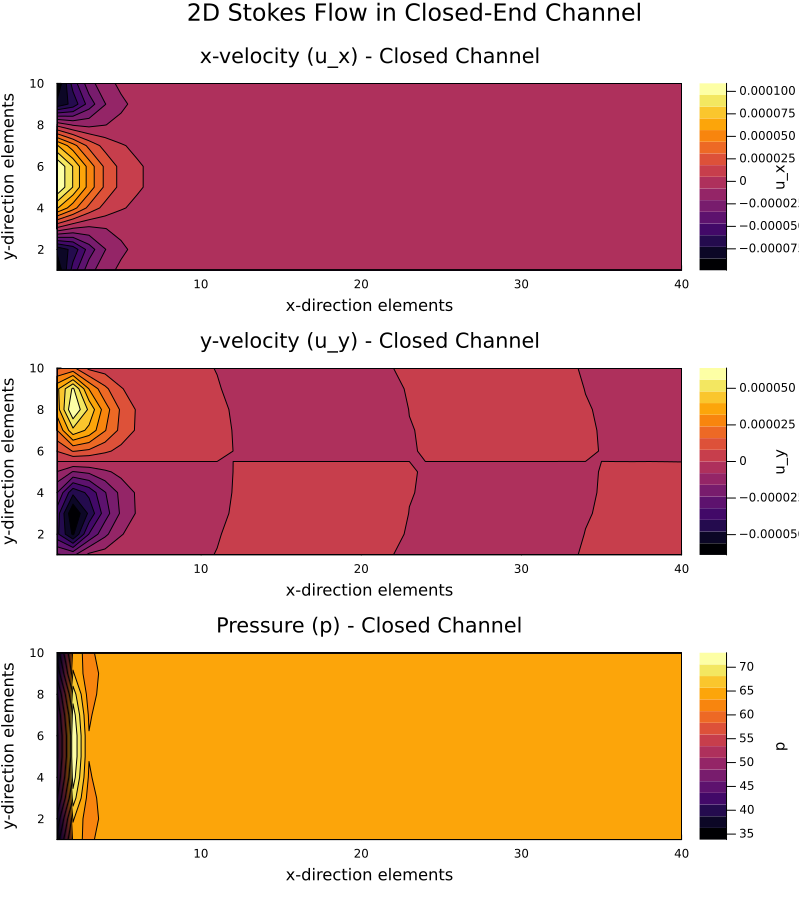

In [47]:
# =============================================================================
# VISUALIZATION 
# =============================================================================

# Post-process the closed channel solution
area_closed, velx2d_closed, vely2d_closed, pres2d_closed = postprocess_solution(u_closed, dh_closed, nels_closed)

# Create visualization plots for closed channel


# Closed channel plots
p1_closed = contour(velx2d_closed', 
                   fill=true, 
                   title="x-velocity (u_x) - Closed Channel", 
                   xlabel="x-direction elements", 
                   ylabel="y-direction elements",
                   colorbar_title="u_x")

p2_closed = contour(vely2d_closed', 
                   fill=true, 
                   title="y-velocity (u_y) - Closed Channel", 
                   xlabel="x-direction elements", 
                   ylabel="y-direction elements",
                   colorbar_title="u_y")

p3_closed = contour(pres2d_closed', 
                   fill=true, 
                   title="Pressure (p) - Closed Channel", 
                   xlabel="x-direction elements", 
                   ylabel="y-direction elements",
                   colorbar_title="p")

# Combine closed channel plots
closed_plot = plot(p1_closed, p2_closed, p3_closed, 
                   layout=(3,1), 
                   size=(800, 900),
                   plot_title="2D Stokes Flow in Closed-End Channel")

# Display the closed channel plot
display(closed_plot)

Theoretical understanding:

In this notebook the steady state stokes solutions were solved for both the open channel and closed vessel. 
The system equations solved were:
$$-\mu \nabla^2 \mathbf{u} + \nabla p = \mathbf{0} \quad \text{(momentum, no time derivative)}$$
$$\nabla \cdot \mathbf{u} = 0 \quad \text{(continuity)}$$

For open channel a steady state existed representing continuous flow through a pipe. For the closed vessel, a steady state solution does not exist (is this correct?). Hence our solutions represents one instant during a transient filling process.
To simulate the closed vessel the transient solution needs to be solved.